# Yield Curve PCA: Exploratory Data Analysis

**Author:** Rakesh KS
**Domain:** Fixed Income & Macro Strategy

This notebook contains the exploratory data analysis (EDA) and mathematical proof-of-concept for extracting the latent factors of the US Treasury yield curve using Principal Component Analysis (PCA).

The goal is to mathematically prove that the first three principal components correspond to the **Level**, **Slope**, and **Curvature** of the yield curve, and to conceptualize a duration-neutral butterfly spread to trade the curvature.

In [ ]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta

# Set plot style for institutional-looking charts
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Data Acquisition
We will fetch 20 years of daily constant maturity Treasury yields from the FRED API. We focus on the 2Y, 5Y, 10Y, and 30Y nodes, which represent the key liquidity points on the curve.

In [ ]:
# Define parameters
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (datetime.today() - timedelta(days=365*20)).strftime('%Y-%m-%d')
tickers = {'2Y': 'DGS2', '5Y': 'DGS5', '10Y': 'DGS10', '30Y': 'DGS30'}

# Fetch data
print(f"Fetching data from {start_date} to {end_date}...")
yields = web.DataReader(list(tickers.values()), 'fred', start_date, end_date)
yields.columns = list(tickers.keys())

# Forward fill missing data and drop NAs
yields = yields.ffill().dropna()

print(f"Data shape: {yields.shape}")
yields.tail()

Fetching data from 2006-02-28 to 2026-02-23...
Data shape: (5213, 4)


,2Y,5Y,10Y,30Y
DATE,,,,
2026-02-13,3.40,3.61,4.04,4.69
2026-02-16,3.40,3.61,4.04,4.69
2026-02-17,3.43,3.63,4.05,4.68
2026-02-18,3.47,3.66,4.09,4.71
2026-02-19,3.47,3.65,4.08,4.70


## 2. Yield Curve Dynamics
Before running PCA, let's visualize the raw yields and calculate the daily basis point changes ($\Delta Y$). PCA requires stationary data, so we run the model on daily *changes* rather than absolute yield levels.

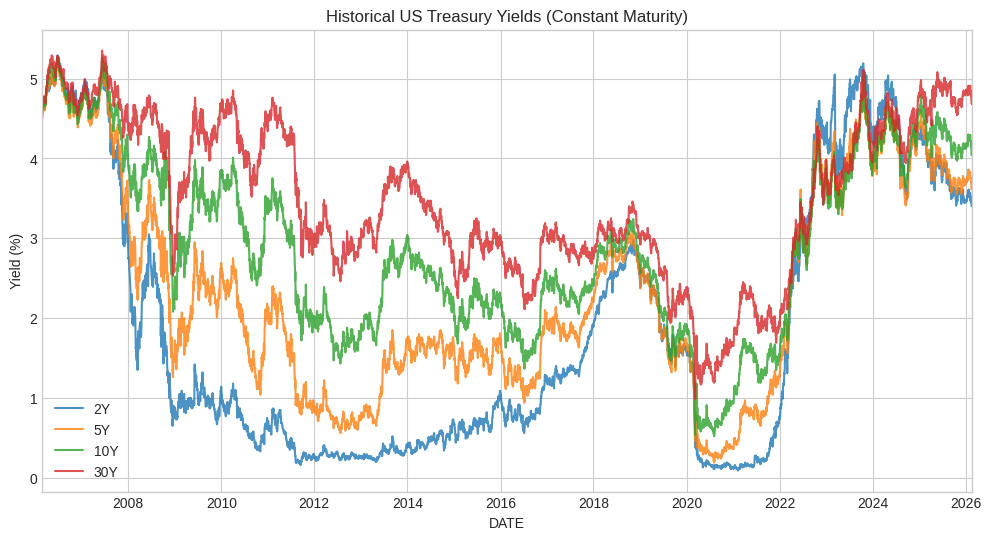

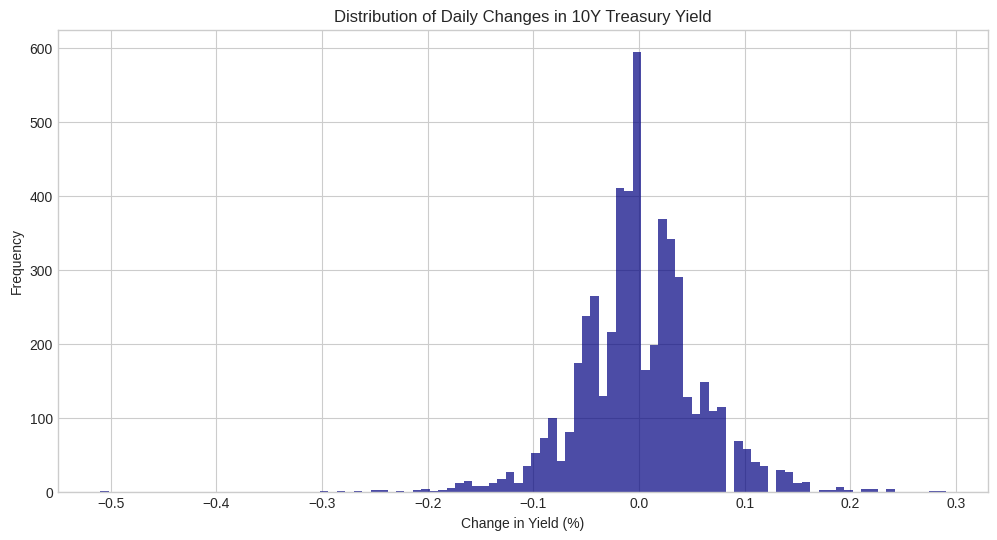

In [ ]:
# Plot historical yield levels
yields.plot(title="Historical US Treasury Yields (Constant Maturity)", ylabel="Yield (%)", alpha=0.8)
plt.show()

# Calculate daily changes (in percentage points / 100 bps)
yield_changes = yields.diff().dropna()

# Plot the distribution of daily changes for the 10Y node
yield_changes['10Y'].hist(bins=100, alpha=0.7, color='navy')
plt.title("Distribution of Daily Changes in 10Y Treasury Yield")
plt.xlabel("Change in Yield (%)")
plt.ylabel("Frequency")
plt.show()

## 3. Principal Component Analysis (PCA)
We apply PCA to the standardized daily yield changes. Standardizing ensures that highly volatile nodes (typically the short end) do not disproportionately dominate the variance matrix.

$$\Sigma V = \lambda V$$
Where $\Sigma$ is the covariance matrix of daily changes, $V$ are the eigenvectors (loadings), and $\lambda$ are the eigenvalues (explained variance).

In [ ]:
# Standardize the daily changes
scaler = StandardScaler()
scaled_changes = scaler.fit_transform(yield_changes)

# Fit PCA
pca = PCA(n_components=3)
pca.fit(scaled_changes)

# Extract explained variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("--- Explained Variance ---")
for i in range(3):
    print(f"PC{i+1}: {explained_var[i]:.2%} (Cumulative: {cumulative_var[i]:.2%})")

--- Explained Variance ---
PC1: 85.60% (Cumulative: 85.60%)
PC2: 12.08% (Cumulative: 97.68%)
PC3: 1.82% (Cumulative: 99.50%)


### 3.1 Analyzing the Factor Loadings
The eigenvectors (loadings) tell us how each node on the curve reacts to a 1-standard-deviation move in the principal component.

* **PC1:** All weights are positive and relatively equal $\rightarrow$ **Level** (Parallel Shift).
* **PC2:** Weights transition from negative (short end) to positive (long end) $\rightarrow$ **Slope** (Steepening/Flattening).
* **PC3:** The 5Y node has a positive weight, while the 2Y and 30Y have negative weights $\rightarrow$ **Curvature** (Butterfly).

                       2Y        5Y       10Y       30Y
PC1 (Level)      0.462508  0.526278  0.526403  0.481682
PC2 (Slope)      0.717557  0.194293 -0.261324 -0.615688
PC3 (Curvature) -0.502712  0.610271  0.313037 -0.526172


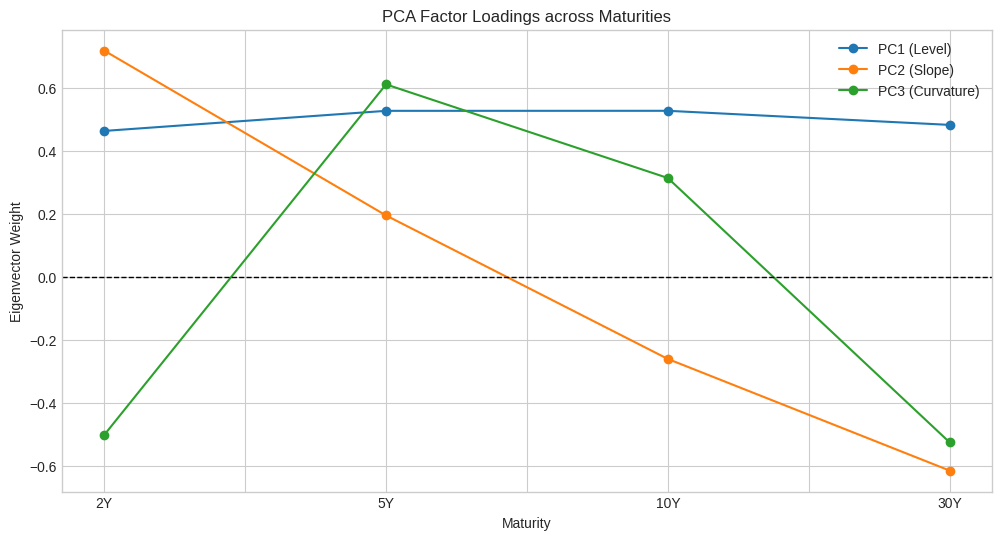

In [ ]:
# Create a DataFrame for the loadings
loadings = pd.DataFrame(
    pca.components_,
    columns=yields.columns,
    index=['PC1 (Level)', 'PC2 (Slope)', 'PC3 (Curvature)']
)

print(loadings)

# Plot the loadings
loadings.T.plot(marker='o', title="PCA Factor Loadings across Maturities")
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylabel("Eigenvector Weight")
plt.xlabel("Maturity")
plt.show()

## 4. Constructing the 2s5s10s Butterfly Spread
To trade PC3 (Curvature) in a mean-reverting strategy, we construct a 2s5s10s spread. We want this to be **Duration-Neutral** so that movements in PC1 (Level) do not impact our PnL.

We approximate par duration as: $D \approx \frac{1 - (1+y)^{-M}}{y}$

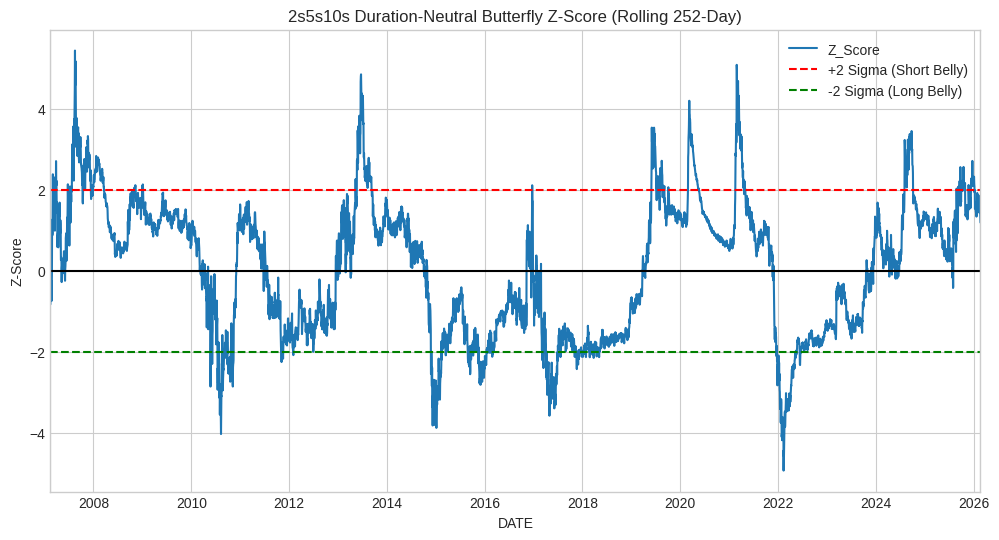

In [ ]:
def calc_duration(y_pct, mat):
    y = y_pct / 100.0
    if y == 0: return float(mat)
    return (1 - (1 + y)**-mat) / y

# Calculate rolling fly spread
fly_yields = []

for date, row in yields.iterrows():
    d2 = calc_duration(row['2Y'], 2)
    d5 = calc_duration(row['5Y'], 5)
    d10 = calc_duration(row['10Y'], 10)

    # Weights (Long 1 unit of 5Y belly, Short the wings matched by duration)
    w5 = 1.0
    w2 = -0.5 * (d5 / d2)
    w10 = -0.5 * (d5 / d10)

    fly_yield = (w2 * row['2Y']) + (w5 * row['5Y']) + (w10 * row['10Y'])
    fly_yields.append(fly_yield)

# Create DataFrame and calculate Z-Score
fly_df = pd.DataFrame({'Fly_Yield': fly_yields}, index=yields.index)
fly_df['Mean_252'] = fly_df['Fly_Yield'].rolling(252).mean()
fly_df['Std_252'] = fly_df['Fly_Yield'].rolling(252).std()
fly_df['Z_Score'] = (fly_df['Fly_Yield'] - fly_df['Mean_252']) / fly_df['Std_252']

fly_df.dropna(inplace=True)

# Plot Z-Score
fly_df['Z_Score'].plot(title="2s5s10s Duration-Neutral Butterfly Z-Score (Rolling 252-Day)")
plt.axhline(2, color='red', linestyle='--', label='+2 Sigma (Short Belly)')
plt.axhline(-2, color='green', linestyle='--', label='-2 Sigma (Long Belly)')
plt.axhline(0, color='black')
plt.ylabel("Z-Score")
plt.legend()
plt.show()